# Natural Language Processing

## 1. Importando Bibliotecas

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns
import unidecode
from nltk import tokenize, RSLPStemmer, FreqDist, tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from string import punctuation

## 2. Leitura dos dados

In [163]:
dataset = pd.read_csv('order_reviews.csv', sep=';')

In [164]:
dataset.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


## 3. Compreensão de dados

### 3.1. Analise de dados faltantes (Null)

In [165]:
dataset.drop(['review_id', 'review_creation_date', 'review_answer_timestamp', 'review_comment_title', 'order_id'], axis=1, inplace=True)

In [166]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_score            99224 non-null  int64 
 1   review_comment_message  40977 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [167]:
# Retirando o valores Null de reviews
dataset = dataset.dropna()
dataset = dataset.reset_index(drop=True)
dataset.shape

(40977, 2)

In [168]:
dataset.head()

,review_score,review_comment_message
0,5,Recebi bem antes do prazo estipulado.
1,5,Parabéns lojas lannister adorei comprar pela I...
2,4,aparelho eficiente. no site a marca do aparelh...
3,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,"Vendedor confiável, produto ok e entrega antes..."


### 3.1. Rotulagem dos dados

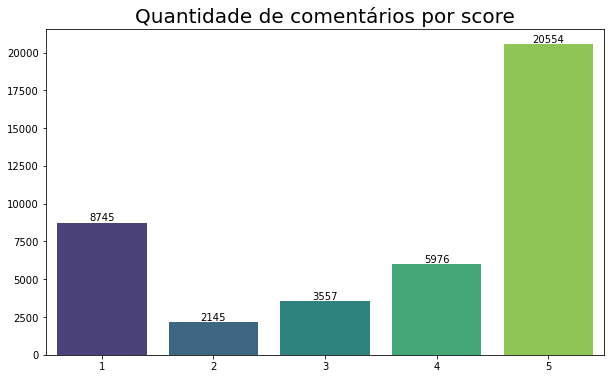

In [169]:
# Criando um datafrem que contem as quantidade de acordo com o score
quantidade = pd.DataFrame(dataset['review_score'].value_counts()).sort_index()

# plotando o gráfico de barra
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(y='review_score', x=quantidade.index, data=quantidade, orient='v', palette='viridis')
ax.set_title('Quantidade de comentários por score', fontdict={'fontsize': 20})
ax.set(ylabel=None, xlabel=None)
ax.bar_label(ax.containers[0])
plt.show()

Com objetivo de criar um modelo de análise sentimental em uma abordagem de Machine Learning supervionada, iremos dividir os sentimetos em três classes: negativo, neutro e positivo. O database não possui uma definição explicita sobre a definição de sentimento para cada comentário. Pensando em uma implementação rápida, utilizaremos a coluna "review_score" para rotular os dados nas três classes já que ela dá uma oa ideia sobre a satisfação do cliente a respeito da compra.

Rotulagem dos dados:
- Positivo (1): Compreende os scores de valores 4 e 5
- Neutro (0): Compreende o score de valor 3
- Negativo (-1): Compreende os scores de valores 1 e 2

In [170]:
# Rotulagem dos dados
score_map = {
    1: -1,
    2: -1,
    3: 0,
    4: 1,
    5: 1
}

dataset['sentiment_label'] = dataset['review_score'].map(score_map)
dataset = dataset[['review_score', 'sentiment_label','review_comment_message']]

In [171]:
dataset.head()

,review_score,sentiment_label,review_comment_message
0,5,1,Recebi bem antes do prazo estipulado.
1,5,1,Parabéns lojas lannister adorei comprar pela I...
2,4,1,aparelho eficiente. no site a marca do aparelh...
3,4,1,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,1,"Vendedor confiável, produto ok e entrega antes..."


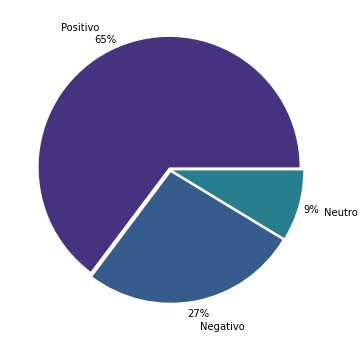

In [172]:
sentiment = pd.DataFrame(dataset['sentiment_label'].value_counts())
labels = ['Positivo', 'Negativo', 'Neutro']

fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette('viridis')
ax.pie(sentiment['sentiment_label'],labels= labels,autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, explode = [0.02, 0.02, 0.02], colors=colors)
plt.show()

## 4. Criando uma BaseLine

### 4.1. Bag of Words: criando representações da linguagem humana.

In [173]:
# Vetorizando as 50 palavras com mais ocorrência da coluna "review_comment_message"
vetorizar = CountVectorizer(max_features=50)
bag_of_words = vetorizar.fit_transform(dataset['review_comment_message'])
bag_of_words.shape

(40977, 50)

In [174]:
# Visualização das 50 palavras com mais ocorrência
print(vetorizar.get_feature_names_out())

['ainda' 'antes' 'as' 'até' 'bem' 'bom' 'chegou' 'com' 'como' 'compra'
 'comprei' 'da' 'de' 'dentro' 'do' 'em' 'entrega' 'entregue' 'estou' 'eu'
 'excelente' 'foi' 'gostei' 'loja' 'mais' 'mas' 'me' 'meu' 'minha' 'muito'
 'na' 'no' 'não' 'os' 'para' 'por' 'prazo' 'produto' 'qualidade' 'que'
 'recebi' 'recomendo' 'rápida' 'super' 'só' 'tudo' 'um' 'uma' 'veio'
 'ótimo']


### 4.2. Modelo: LogisticRegression 

In [175]:
# verificar a proporção do review score
dataset.review_score.value_counts().sort_index()

1     8745
2     2145
3     3557
4     5976
5    20554
Name: review_score, dtype: int64

In [176]:
# Separando os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(bag_of_words,\
                                                        dataset['sentiment_label'],\
                                                            stratify=dataset['sentiment_label'],
                                                                random_state = 42)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(30732, 50)
(10245, 50)
(30732,)
(10245,)


In [177]:
regressao_logistica = LogisticRegression(solver = "lbfgs")
regressao_logistica.fit(x_train, y_train)
regressao_logistica.score(x_test, y_test)

0.7958028306490971

### 4.3. Função para classificar sentimentos

A função classificar_texto será utilizada para gerar o Score do modelo de LogisticRegression para facilitar a comparação com a baseline. Todos os parâmetros ficaram constante para ser possível analise apenas as mudanças realizadas nos reviews.

In [178]:
def classificar_texto(dataset, coluna_texto, coluna_classificacao):
    '''
    dataset: Dataframe (Pandas)
        Conjunto de dados 
    coluna_texto: String
        Nome da coluna que possui os textos a serem claficados
    coluna_classificacao: String
        Nome da coluna que possui os valores de classficação dos reviews
    '''
    vetorizar = CountVectorizer(max_features=50)
    bag_of_words = vetorizar.fit_transform(dataset[coluna_texto])
    treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words,
                                                              dataset[coluna_classificacao],
                                                              stratify=dataset[coluna_classificacao],
                                                              random_state = 42)
    regressao_logistica = LogisticRegression(solver = "saga", multi_class='multinomial')
    regressao_logistica.fit(treino, classe_treino)
    return regressao_logistica.score(teste, classe_teste)


In [179]:
baseline = classificar_texto(dataset, "review_comment_message", 'sentiment_label')
baseline

0.7959980478282089

## 5. Visualizações

### 5.1. WordCloud

Word cloud é uma imagem gerada com as principais palavras de um texto distribuídas em um espaço, de modo que o tamanho de cada palavra é proporcional à sua frequência de aparição nos dados. Ela vai ajudar a ter ideias de como realizar tratamentos em seu texto para melhorar os resultados.Plotando as palavras mais frequentes para todos os tipos de comentarios através do WordCloud:

In [74]:
# Fazendo um list compression para capturar todas as palavras de todos rewies
todas_palavras = ' '.join([texto for texto in dataset.review_comment_message])
len(todas_palavras)

2853542

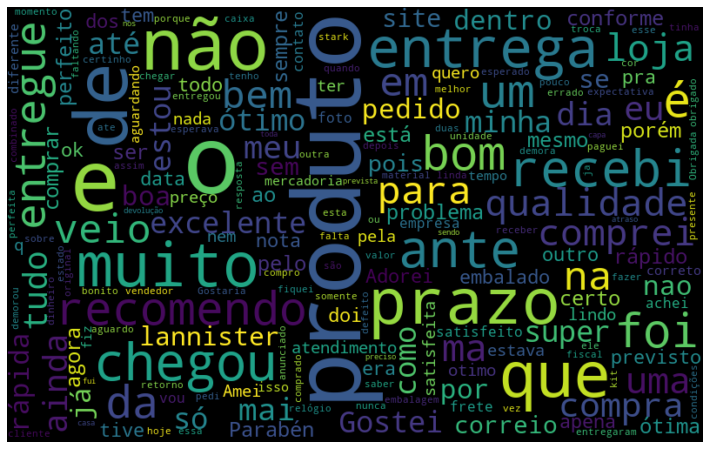

In [75]:
%matplotlib inline

# gerando a wordcloud
nuvem_palavras = WordCloud(width=800,\
                             height=500, 
                                max_font_size=110,\
                                    collocations=False).generate(todas_palavras)

# trasformando o objeto gerado em uma imagem
plt.figure(figsize=(14, 8))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis('off')
plt.show()

Sendo a base de dados um review da venda, logo, a palavra que possui maior número de ocorrência é "produto". Há também grande número de ocorrência de palavras que não agregam semanticamente no momento de criação do modelo, como por exemplo, "o", "que", "e", "da", "de" e "como".

Plotando palavras que nos remete a cada tipo de Score do Review:

In [76]:
# Criando dataframes para cada categoria de review
score_1 = dataset[dataset['review_score'] == 1]
score_2 = dataset[dataset['review_score'] == 2]
score_3 = dataset[dataset['review_score'] == 3]
score_4 = dataset[dataset['review_score'] == 4]
score_5 = dataset[dataset['review_score'] == 5]

Definindo uma função para criação das nuvem de palavras de acordo com o valor do score:

In [77]:
def nuvem_palavras(dataset, coluna_texto, n_score):
    '''
    dataset: Dataframe (Pandas)
        Conjunto de dados 
    coluna_texto: String
        Nome da coluna que possui os textos a serem claficados
    n_score: Integer
        Valor do Score que se dejesa plotar a nuvem de palavras (WordCloud)
    '''
    score = dataset[dataset['review_score'] == n_score]
    palavras = ' '.join([texto for texto in score[coluna_texto]])
    # gerando a wordcloud
    nuvem_palavras = WordCloud(width=800,\
                                height=500, 
                                    max_font_size=110,\
                                        collocations=False).generate(palavras)

    # trasformando o objeto gerado em uma imagem
    plt.figure(figsize=(14, 8))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis('off')
    plt.show()

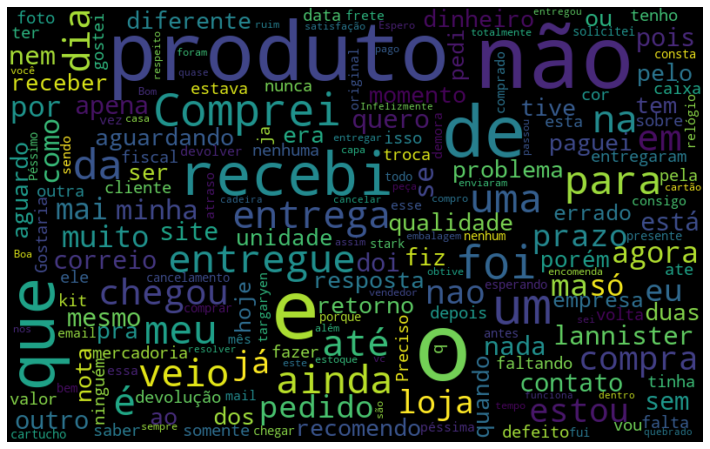

In [78]:
# Para o valor de score 1:
nuvem_palavras(dataset, 'review_comment_message', 1)

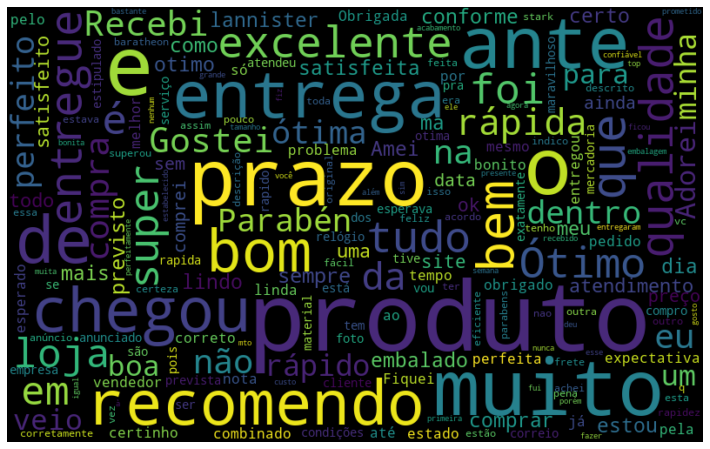

In [79]:
# Para o valor de score 5:
nuvem_palavras(dataset, 'review_comment_message', 5)

### 5.2. Gráfico de barra

#### 5.2.1. NLTK

Calculo para frequência das palavras:

In [80]:
# Dividindo as strings uma lista de substrings:
token_espaco = tokenize.WhitespaceTokenizer()
token_espaco = token_espaco.tokenize(todas_palavras)

In [81]:
# Calculando a frência das palavras
# Irá ser retornado um dicionario com todas as palavras, onde a chave é palavra 
# o valor é número de ocorrência 
frequencia = nltk.FreqDist(token_espaco)

In [82]:
# Criando um dataframe com a frequencia
df_frequencia = pd.DataFrame({
    'Palavra' : list(frequencia.keys()),
    'Frequencia' : list(frequencia.values())
    })

df_frequencia.nlargest(columns='Frequencia', n=10)

,Palavra,Frequencia
39,o,14802
14,e,14746
50,produto,11069
122,de,10833
3,do,10813
16,a,10321
114,não,8298
37,que,7984
82,muito,5408
2,antes,5343


#### 5.2.2. Função para visualização das palavras mais frequêntes

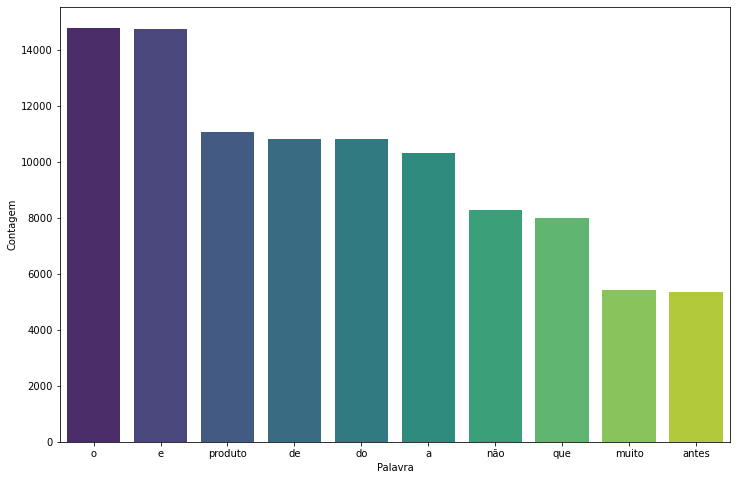

In [154]:
def grafico_barra(texto, coluna_texto, quantidade):
    '''
    Args:
    ----------
    dataset: Dataframe (Pandas)
        Conjunto de dados 
    coluna_texto: String
        Nome da coluna que possui os textos a serem claficados
    quantidade: Integer
        Número de palavras a serem plotadas no gráfico de barra
    '''
    todas_palavras = ' '.join([texto for texto in texto[coluna_texto]])
    token_espaco = tokenize.WhitespaceTokenizer()
    token_frase = token_espaco.tokenize(todas_palavras)
    frequencia = nltk.FreqDist(token_frase)
    df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                                   "Frequência": list(frequencia.values())})
    df_frequencia = df_frequencia.nlargest(columns = "Frequência", n = quantidade)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequencia, x = "Palavra", y = "Frequência", palette='viridis')
    ax.set(ylabel = "Contagem")
    plt.show()

grafico_barra(dataset, "review_comment_message", 10)

## 6. Expressões Regulares

Sabendo que os dados são fruto de comentarios da internet, provalmente será necessário lidar com algumas expressões regulares. Iremos realizar o pré-processamento dos dados, substituido as expressões regulares por termos que as caracterizem de forma simples.

### 6.1. Datas

As datas são expressões bastantes comuns em reviews de clientes sobre itens comprados online. Vamos criar uma função para substituir todas as datas pela string 'data'.

In [84]:
def re_dates(texto_lista):
    '''
    Argumentos:
    ----------
    texto_lista: list
        Lista contentdo o texto para ser tratado
    '''
    # Criando a RegEx
    padrao = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    return [re.sub(padrao, ' data ', r) for r in texto_lista]

In [85]:
# Criando a lista de comentarios
reviews = list(dataset['review_comment_message'].values)
# Aplicando o re_dates
review_dates = re_dates(reviews)
dataset['re_dates'] = review_dates

### 6.2. Dinheiros (valores em reais)

Outro padrão que é bastante comum em reviews de compra é a representação de dinheiro (R$_,_). Iremos trasformar todas os valores em uma string 'valor'.

In [86]:
def re_money(text_list):
    """
    Argumentos:
    ----------
    texto_lista: list
        Lista contentdo o texto para ser tratado
    """
    
    # Criando a RegEx
    pattern = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return [re.sub(pattern, ' dinheiro ', r) for r in text_list]

In [87]:
# Aplicando o re_money
review_money = re_money(review_dates)
dataset['re_money'] = review_money

### 6.3. Negação

Na remoção de StopWords, provavelmente perderíamos o significado de algumas frases de negação, já que o termo 'não' é removido. Então, por causa disso, iremos substituir todos as RegEx que representa o termo 'não' por negação.

In [88]:
def re_negation(text_list):
    """
    Argumentos:
    ----------
    texto_lista: list
        Lista contentdo o texto para ser tratado
    """
    
    # Criando a RegEx
    return [re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', r) for r in text_list]

In [89]:
# Aplicando o re_money
reviews_negation = re_money(review_money)
dataset['re_negation'] = reviews_negation

### 6.4. Caracteres Especiais (incluindo emojis)

A utilização de caracteres especiais e emojis são bastantes utilizados em comentarios onlines. Logo, iremos remover todos.

In [90]:
def re_special_chars(text_list):
    """
    Argumentos:
    ----------
    texto_lista: list
        Lista contentdo o texto para ser tratado
    """
    
    # Criando a RegEx
    return [re.sub('\W', ' ', r) for r in text_list]

In [91]:
# Applying RegEx
reviews_special_chars = re_special_chars(reviews_negation)
dataset['re_special_chars'] = reviews_special_chars

### 6.5. Espaços (whitespaces) adicionais

Iremos remover os espaços desnecessários já existentes ou criados devido as etapas anteriores.

In [92]:
def re_whitespaces(text_list):
    """
    Argumentos:
    ----------
    texto_lista: list
        Lista contentdo o texto para ser tratado
    """
    
    # Criando a RegEx
    white_spaces = [re.sub('\s+', ' ', r) for r in text_list]
    white_spaces_end = [re.sub('[ \t]+$', '', r) for r in white_spaces]
    return white_spaces_end

In [93]:
# Applying RegEx
reviews_whitespaces = re_whitespaces(reviews_special_chars)
dataset['re_whitespaces'] = reviews_whitespaces

### 6.6 Números

Removeremos todos os números nas avaliações e substituí-los por outra string "numero" para que gere nem uma perda de infomação.

In [95]:
def re_numbers(text_list):
    """
    Argumentos:
    ----------
    texto_lista: list
        Lista contentdo o texto para ser tratado
    """
    
    # Criando a RegEx
    return [re.sub('[0-9]+', ' numero ', r) for r in text_list]

In [96]:
# Applying RegEx
reviews_numbers = re_numbers(reviews_whitespaces)
dataset['re_numbers'] = reviews_numbers

In [108]:
dataset.head()

,review_score,review_comment_message,re_dates,re_money,re_negation,re_special_chars,re_whitespaces,re_numbers,stopwords_removed,reviews_normalization,reviews_stemmer
0,5,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado,Recebi bem antes do prazo estipulado,Recebi bem antes do prazo estipulado,recebi bem antes prazo estipulado,recebi bem antes prazo estipulado,receb bem ant praz estipul
1,5,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela I...,parabéns lojas lannister adorei comprar intern...,parabens lojas lannister adorei comprar intern...,parab loj lannist ador compr internet segur pr...
2,4,aparelho eficiente. no site a marca do aparelh...,aparelho eficiente. no site a marca do aparelh...,aparelho eficiente. no site a marca do aparelh...,aparelho eficiente. no site a marca do aparelh...,aparelho eficiente no site a marca do aparelh...,aparelho eficiente no site a marca do aparelho...,aparelho eficiente no site a marca do aparelho...,aparelho eficiente site marca aparelho impress...,aparelho eficiente site marca aparelho impress...,aparelh efici sit marc aparelh impress numer d...
3,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.\r\n",Mas um pouco travando pelo valor ta Boa,Mas um pouco travando pelo valor ta Boa,Mas um pouco travando pelo valor ta Boa,pouco travando valor ta boa,pouco travando valor ta boa,pouc trav val ta boa
4,5,"Vendedor confiável, produto ok e entrega antes...","Vendedor confiável, produto ok e entrega antes...","Vendedor confiável, produto ok e entrega antes...","Vendedor confiável, produto ok e entrega antes...",Vendedor confiável produto ok e entrega antes...,Vendedor confiável produto ok e entrega antes ...,Vendedor confiável produto ok e entrega antes ...,vendedor confiável produto ok entrega antes prazo,vendedor confiavel produto ok entrega antes prazo,vend confia produt ok entreg ant praz


## 7. Removendo Stop Words

As stop words são palavras que não apresentam relevância em determinado contexto e podem ser removidas sem perda semântica da frase. Essa lista não é fixa e universal, podendo ser alterada dependendo do contexto e idioma. Livrar-se dessas palavras faz muito sentido para qualquer tarefa de Processamento de Linguagem Natural.

In [97]:
# Baixando o conjunto de palavras Stop Words da NLTK
nltk.download('stopwords')
palavras_irrelevantes = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Brothers\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [98]:
# Visualização de 15 StopWord definidas na biblioteca NLTK
print(palavras_irrelevantes[:15])

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da']


In [99]:
# Definição da função para remover as StopWords e trasformar os comentarios em minusculo
def stopwords_removal(texto_lista, stopwords_lista):
    '''
    Argumentos:
    ----------
    texto_lista: list
        Lista contentdo o texto em que será removida as topwords
    stopwords_lista: list
        Lista contendo as stopword
    '''
    return [c.lower() for c in texto_lista.split() if c.lower() not in stopwords_lista]

In [100]:
# Removendo as stopword do dataset
reviews_stopwords = [' '.join(stopwords_removal(review, palavras_irrelevantes)) for review in reviews_numbers]
dataset['stopwords_removed'] = reviews_stopwords

## 8. Normalização de textos

In [101]:
# Defining a function to remove the stopwords and to lower the comments
def normalization_process(texto_lista):
    '''
    Argumentos:
    ----------
    texto_lista: list
        Lista contentdo o texto em que será normalizada
    '''
    return [unidecode.unidecode(c) for c in texto_lista.split()]

In [102]:
# Applying stemming and looking at some examples
reviews_normalization = [' '.join(normalization_process(review)) for review in reviews_stopwords]
dataset['reviews_normalization'] = reviews_normalization

## 9. Stemming

Stemming é a técnica que transforma as flexões de uma palavra em um núcleo comum (tronco).  Essa técnica normaliza as palavras de forma a evitar suas flexões e derivações. Existem diversos algoritmos para realizar a “stemmização", seja em Português, sejam em outros idiomas.

In [103]:
# Realizando download do stemming para a linguagem Pt-br
nltk.download('rslp')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\Brothers\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [104]:
def stemming_process(texto_lista, stemmer=RSLPStemmer()):
    '''
    Argumentos:
    ----------
    texto_lista: list
        Lista contentdo o texto em que será normalizada
    stemmer: class, default: RSLPStemmer()
        Tipo de Stemmer que será aplicado ao texto
    '''
    
    return [stemmer.stem(c) for c in texto_lista.split()]

In [105]:
# Aplicando o processor de Stemmer nos dados
reviews_stemmer = [' '.join(stemming_process(review)) for review in reviews_normalization]
dataset['reviews_stemmer'] = reviews_stemmer

## 10. Extração de Features de texto

A extração de features de texto envolve resumir automaticamente o texto e encontrar palavras importantes. Um exemplo disso é a extração de palavras-chave, que extrai as palavras mais importantes do texto, o que pode ser útil para a otimização de mecanismos de busca. Para facilitar nossa análise, vamos definir uma função que recebe um texto e um objeto vetorizador e aplica a extração de recursos no respectivo texto.

In [114]:
def extract_features_from_corpus(texto_lista, vectorizer, df=False):
    '''
    Argumentos:
    ----------
    texto_lista: list
        Lista contentdo o texto em que será normalizada
    vectorizer: object
        Engenharia utilizada para extração das features de texto
    '''

    # Extracting features
    corpus_features = vectorizer.fit_transform(texto_lista).toarray()
    features_names = vectorizer.get_feature_names_out()
    df_corpus_features = None
    if df:
        # Transforming into a dataframe to give interpetability to the process
        df_corpus_features = pd.DataFrame(corpus_features, columns=features_names)
    
    return corpus_features, df_corpus_features

### 10.1. CountVectorizer

O CountVectorizer converte uma coleção de documentos de texto em uma matriz de contagens de token , ou seja, essa implementação produz uma representação esparsa das contagens de frequência das palavras ao longo de todo o dataset.

In [115]:
# Criando a classe de objeto CountVectorizer
count_vectorizer = CountVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=palavras_irrelevantes)

# Extraindo as features de texto a partir do CountVectorizer
_, df_countv_features = extract_features_from_corpus(reviews_stemmer, count_vectorizer, True)
df_countv_features.head()

,abr,acab,ach,acontec,acord,ador,adquir,agil,agor,aguard,...,val,vc,vei,vem,vend,ver,vez,vier,volt,vou
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [113]:
df_countv_features.to_numpy()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### 10.2. TF-IDF

O valor TF-IDF (Term Frequency-Inverse Document Frequency), é uma medida estatística que tem o intuito de indicar a importância de uma palavra de um documento em relação a uma coleção de documentos ou em um corpus linguístico.  O TF-IDF irá contar a frequência das palavras e atribui pesos as mesmas, ponderando-as em todo o dataset. Se uma palavra aparece muitas vezes, ela perde o poder de diferenciação, logo, possuirá um peso menor.

In [116]:
# Criando a classe de objeto TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=palavras_irrelevantes)

# Extraindo as features de texto a partir do TF-IDF
_, df_tfidf_features = extract_features_from_corpus(reviews_stemmer, tfidf_vectorizer, True)
df_tfidf_features.head()

,abr,acab,ach,acontec,acord,ador,adquir,agil,agor,aguard,...,val,vc,vei,vem,vend,ver,vez,vier,volt,vou
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.307476,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.196667,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.591471,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.455039,0.0,0.000000,0.0,0.0,0.0


In [47]:
tfidf = TfidfVectorizer(lowercase=False, max_features=50)
tfidf_tratados = tfidf.fit_transform(dataset['reviews_stemmer'])

x_train, x_test, y_train, y_test = train_test_split(tfidf_tratados,
                                                        dataset['review_score'],
                                                        stratify=dataset['review_score'],
                                                        random_state = 42)

regressao_logistica.fit(x_train, y_train)
acuracia_tfidf = regressao_logistica.score(x_test, y_test)
acuracia_tfidf

c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6483162518301611

A aplicacção do TF-IDF não resultou em melhoras significativas para melhora da acuracia do modelo. O metodo resultou em uma melhora de aproximadamente 0.3% de melhora em comparação com a baseline.

## Ngrams

O método que estávamos utilizando até agora (bag of words), tanto com contagem de frequência quanto aplicando o TF-IDF, não gera um valor que preserve a sequência de palavras. O N-grams considera essencialmente uma sequência de palavras que aparecem na mesma "janela" ao mesmo tempo.

In [66]:
tfidf = TfidfVectorizer(lowercase=False, ngram_range=(1,2))
vetor_tfidf = tfidf.fit_transform(dataset['tratamento_3'])

x_train, x_test, y_train, y_test = train_test_split(vetor_tfidf,
                                                        dataset['review_score'],
                                                        stratify=dataset['review_score'],
                                                        random_state = 42)

regressao_logistica.fit(x_train, y_train)
acuracia_tfidf_ngrams = regressao_logistica.score(x_test, y_test)
acuracia_tfidf_ngrams

c:\Users\Brothers\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.687652513421181

A aplicação do N-grams no modelo resultou em uma melhora de 4% na acuracia.

Visualiando as palavras com maiores relevância

In [68]:
pesos = pd.DataFrame(
    regressao_logistica.coef_[0].T,
    index=tfidf.get_feature_names_out()
)

pesos.nlargest(10,0)

,0
pess,4.476520
cancel,3.191783
agor,2.977174
dinh,2.752813
nad,2.681185
retorn,2.680812
respost,2.485604
pag,2.481548
ruim,2.341225
envi,2.322842


In [69]:
pesos.nsmallest(10,0)

,0
otim,-4.897458
bom,-4.191587
rap,-4.124945
ant,-3.753748
perfeit,-3.420739
bem,-3.092548
boa,-3.061420
lind,-2.999111
tud,-2.747872
bonit,-2.719474
